In [18]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import haversine_distances
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read Table and fetch unique naptan Ids already captured
PROJECT_ID = 'lon-trans-streaming-pipeline'

BQ_client = bigquery.Client(project=PROJECT_ID)
data_set = 'bus_density_streaming_pipeline'
table = 'stopspoint_coordinates'

# SQL query — adjust table name
query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{data_set}.{table}`
"""
result =  BQ_client.query(query)

stations_mapping_raw = pd.DataFrame([{'naptanId': row[0], 'commonName': row[1], 'latitude': row[2], 'longitud': row[3]} for row in result])

In [4]:
print(stations_mapping_raw.shape)
stations_mapping_raw.head()

(19451, 4)


,naptanId,commonName,latitude,longitud
0,490011015S,Pinkwell Park,51.50011,-0.44156
1,490011312W,Queen Elizabeth's Walk,51.56497,-0.08800
2,490012841W,Stokesby Road,51.35862,-0.29849
3,490013978C,Whittington Avenue,51.52340,-0.42175
4,490014495R,Westminster Abbey,51.49923,-0.13045


In [5]:
coords_rad = np.radians(stations_mapping_raw[['latitude', 'longitud']].values)

In [6]:
coords_rad

array([[ 8.98846485e-01, -7.70667585e-03],
       [ 8.99978505e-01, -1.53588974e-03],
       [ 8.96377018e-01, -5.20963328e-03],
       ...,
       [ 9.01394316e-01, -2.00067092e-03],
       [ 8.98998677e-01, -1.88146493e-04],
       [ 8.99924225e-01, -2.61973921e-03]], shape=(19451, 2))

In [7]:
# Run DBSCAN

kms_per_radian = 6371.0088
eps_km = 0.35                     # tweak for London density
db = DBSCAN(
        eps=eps_km / kms_per_radian,
        min_samples=4,
        algorithm='ball_tree',
        metric='haversine'
     ).fit(coords_rad)

stations_mapping_raw['cluster'] = db.labels_

In [8]:
stations_mapping_raw.groupby('cluster').count()['naptanId']

cluster
-1      1004
 0       124
 1      7627
 2        15
 3        13
        ... 
 491       5
 492       4
 493       4
 494       3
 495       4
Name: naptanId, Length: 497, dtype: int64

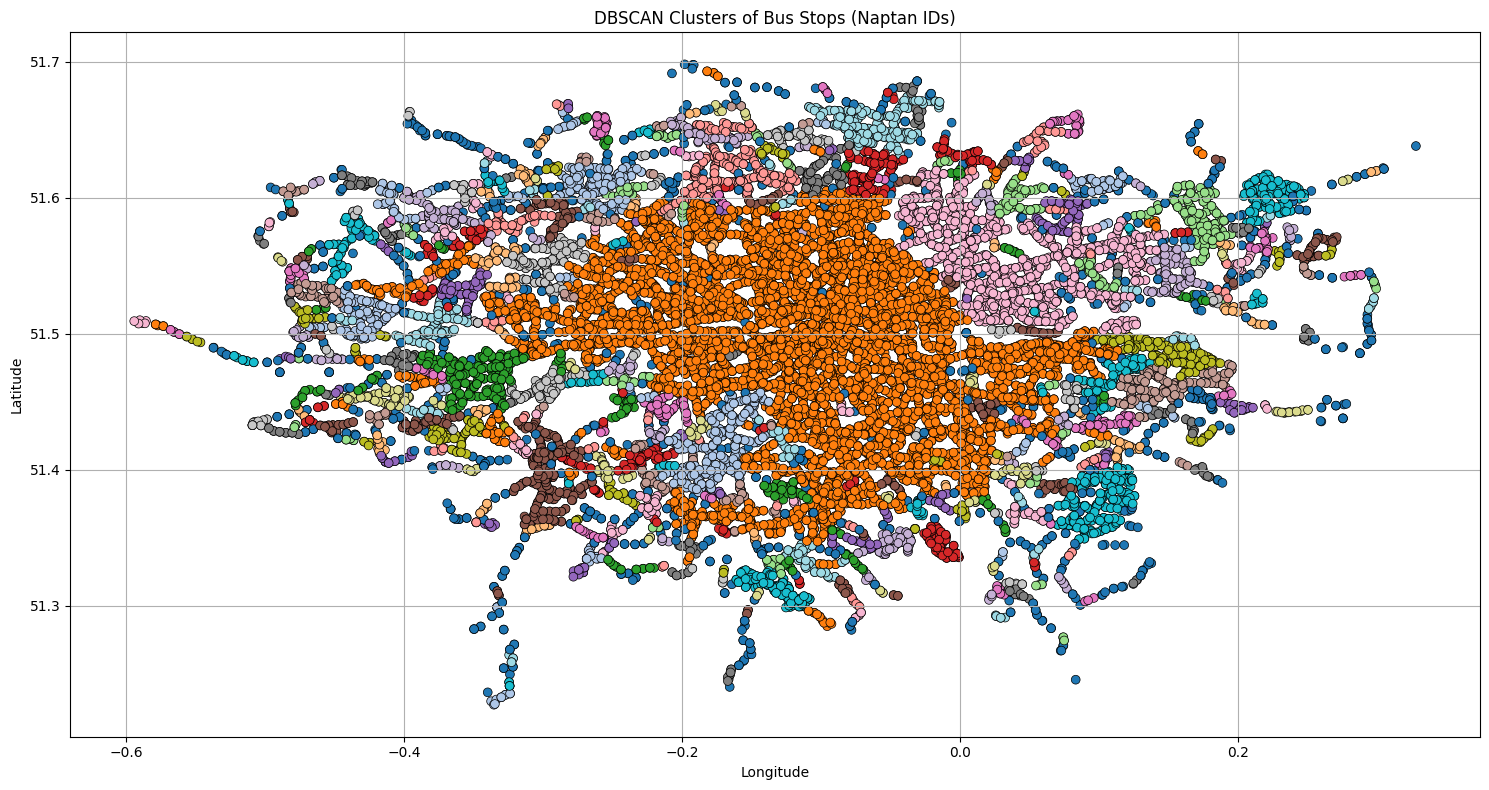

In [9]:
# df_plot = stations_mapping_raw[stations_mapping_raw['cluster'] != -1]
df_plot = stations_mapping_raw
# df_plot = stations_mapping_raw[stations_mapping_raw['cluster'].isin([-1, 0,1,2,3,4,5])]

plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=df_plot,
    x='longitud',
    y='latitude',
    hue='cluster',
    palette='tab20',  
    s=40,
    edgecolor='black'
)
plt.title("DBSCAN Clusters of Bus Stops (Naptan IDs)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Kmeans Test
coords_KMeans = stations_mapping_raw[['latitude', 'longitud']]

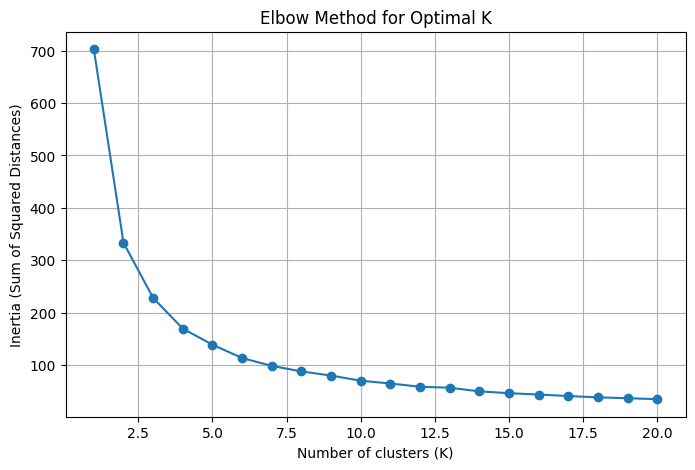

In [11]:
inertia = []
K_range = range(1, 21)  # Try K=1 to K=20

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords_KMeans)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [12]:
optimal_k = 100
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
stations_mapping_raw['cluster_KMeans'] = kmeans.fit_predict(coords_KMeans)

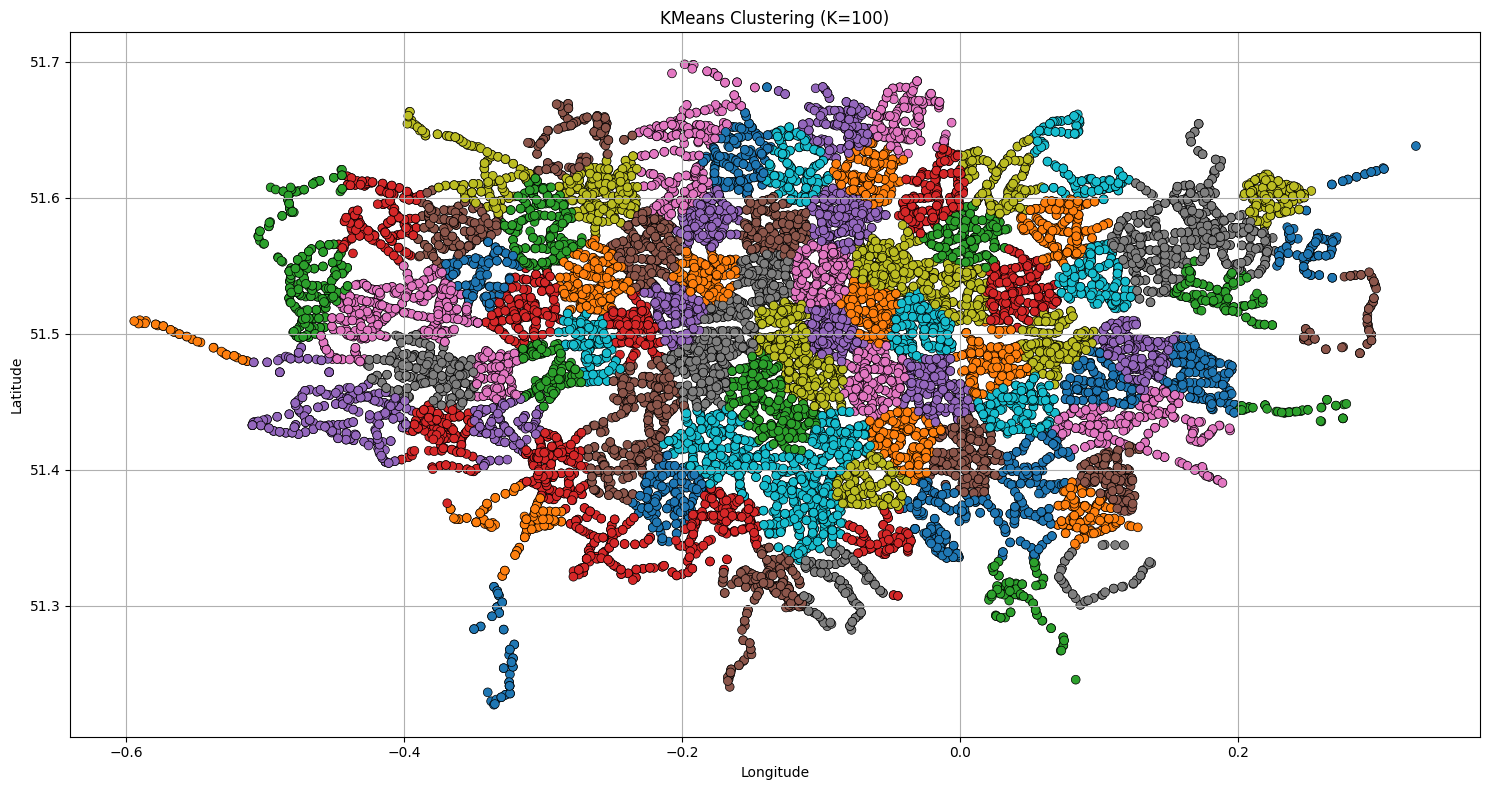

In [13]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=stations_mapping_raw,
    x='longitud',
    y='latitude',
    hue='cluster_KMeans',
    palette='tab10',
    s=40,
    edgecolor='black'
)
plt.title(f"KMeans Clustering (K={optimal_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Aglomerative Clustering

model = AgglomerativeClustering(
    distance_threshold=0.005,   # ~0.01 degrees = ~1km
    
    n_clusters=None,           # required when using distance threshold
    linkage='ward'
)

stations_mapping_raw['clusterAgglomerative'] = model.fit_predict(coords_rad)

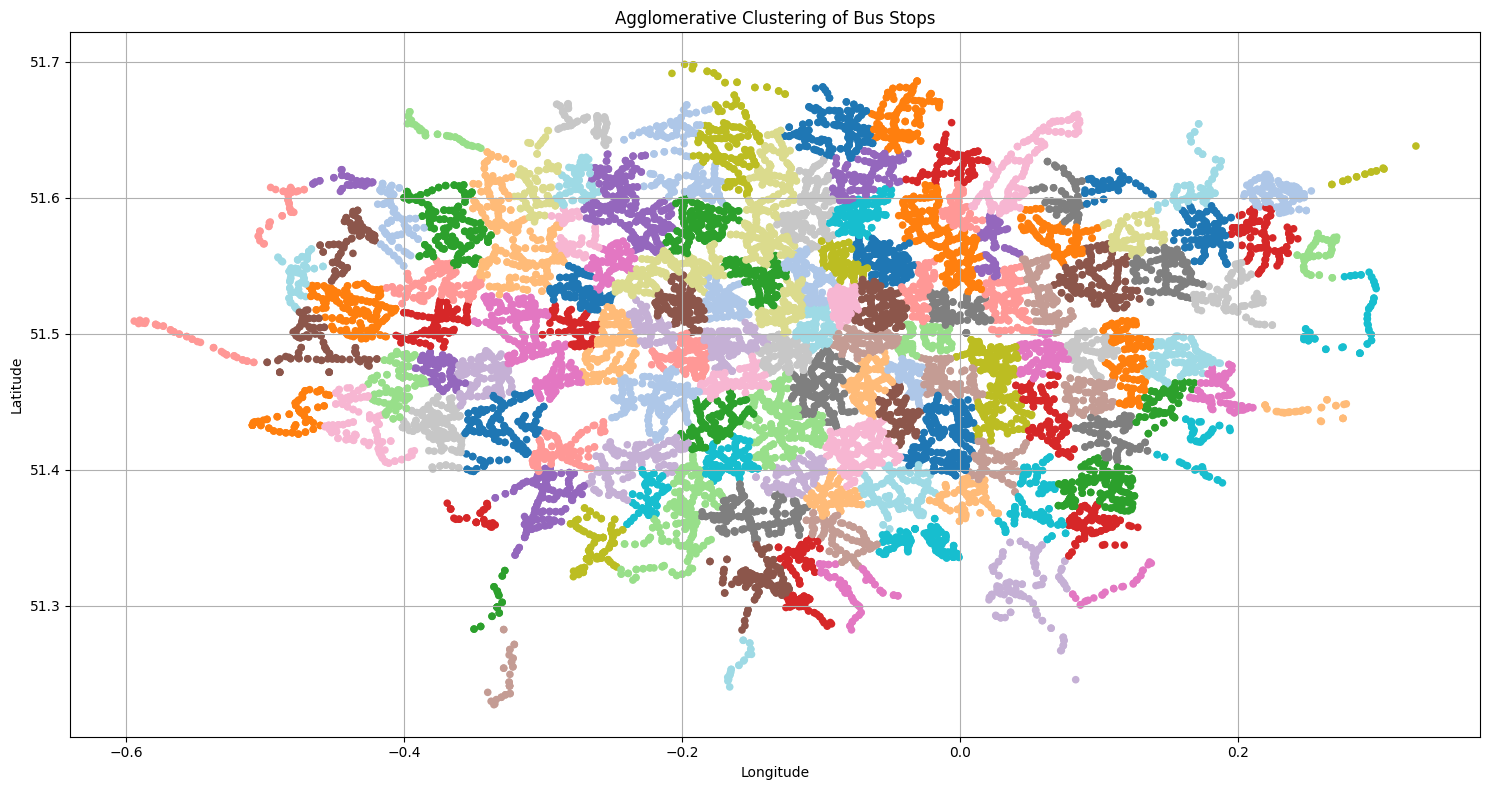

In [15]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=stations_mapping_raw,
    x='longitud',
    y='latitude',
    hue='clusterAgglomerative',
    palette='tab20',
    s=30,
    linewidth=0,
)
plt.title("Agglomerative Clustering of Bus Stops")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend().remove()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
coords_rad_dist = np.radians(stations_mapping_raw[['latitude', 'longitud']].values)

radii = []

for cluster_id in np.unique(stations_mapping_raw['clusterAgglomerative']):
    cluster_points = coords_rad_dist[stations_mapping_raw['clusterAgglomerative'] == cluster_id]
    if len(cluster_points) <= 1:
        continue  # skip noise or single-point clusters

    # Compute cluster centroid in radians
    centroid = cluster_points.mean(axis=0).reshape(1, -1)

    # Haversine distances to centroid (in radians)
    distances = haversine_distances(cluster_points, centroid)

    # Convert to km
    distances_km = distances * 6371.0088

    # Take average distance (i.e. avg cluster radius)
    avg_radius = distances_km.mean()
    radii.append(avg_radius)

In [28]:
import statistics

print(f"Average cluster radius: {statistics.mean(radii):.2f} km")
print(f"Max cluster radius: {max(radii):.2f} km")
print(f"Min cluster radius: {min(radii):.2f} km")

Average cluster radius: 1.29 km
Max cluster radius: 2.42 km
Min cluster radius: 0.82 km
